In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

In [2]:
from pathlib import Path
local_data = Path("/Users/watson-parris/Local Data/ClimateBench/train_val/")

### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [4]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(local_data, train_files)
y_train_tas = create_predictdand_data(local_data, train_files)['tas'].values.reshape(-1, 96 * 144)

In [5]:
X_test = create_test_data(local_data, 'ssp245-aer', eof_solvers)
Y_test = xr.open_dataset(local_data / 'outputs_ssp245-aer.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [6]:
# Drop rows including nans
# nan_train_mask = X_train.isna().any(axis=1).values
# X_train = X_train.dropna(axis=0, how='any')
# y_train_tas = y_train_tas[~nan_train_mask]
# assert len(X_train) == len(y_train_tas)

# nan_test_mask = X_test.isna().any(axis=1).values
# X_test = X_test.dropna(axis=0, how='any')
# tas_truth = tas_truth[~nan_test_mask]

In [7]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [8]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [9]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2022-05-12 15:05:56.883798: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [11]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [15]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

2022-05-11 14:41:46.599750: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13243D+07    |proj g|=  2.67085D+06

At iterate    1    f=  4.84592D+06    |proj g|=  1.26533D+06

At iterate    2    f=  4.50689D+06    |proj g|=  2.01663D+05

At iterate    3    f=  4.45722D+06    |proj g|=  1.94814D+05

At iterate    4    f=  4.00552D+06    |proj g|=  8.75422D+05

At iterate    5    f=  3.69694D+06    |proj g|=  5.41098D+05

At iterate    6    f=  3.59269D+06    |proj g|=  3.97138D+04

At iterate    7    f=  3.58496D+06    |proj g|=  4.11581D+04

At iterate    8    f=  3.58323D+06    |proj g|=  2.40565D+04

At iterate    9    f=  3.57973D+06    |proj g|=  2.11713D+04

At iterate   10    f=  3.57447D+06    |proj g|=  7.83664D+04

At iterate   11    f=  3.56770D+06    |proj g|=  1.07301D+05

At iterate   12    f=  3.56059D+06    |proj g|=  7.37486D+04

At iterate   13    f=  3.5

      fun: 3345284.4598311996
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 10.59992539,   8.96344847,  14.91783706,  20.99665654,
       -18.03292707,   0.10164028,   3.11962089,   2.22355073,
        -9.82796442,  18.38765263,  -7.90946714,  -2.04966791,
         6.47158012,  -5.38194223,   6.58747173,  12.26427955,
        80.25987043,  19.54431406])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 387
      nit: 328
     njev: 387
   status: 0
  success: True
        x: array([  9.78736531,   9.32039237,   0.17451836,  -2.39486879,
        -3.52217483,  19.68465917,   1.91563734,   7.32952328,
        -2.70351661,  -2.8679885 ,  14.69221673,  15.50424973,
        29.07986978, 134.92690854, 112.35202043,   0.73350114,
        -2.52414206,   0.52549183])


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18    328    387      1     0     0   8.026D+01   3.345D+06
  F =   3345284.4598311996     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


### Predict on testing set

In [16]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.loc[2021:, :].values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_stddev = np.sqrt(standard_posterior_var) * train_tas_std

In [17]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [80, 96, 144])
posterior_tas_stddev = np.reshape(posterior_stddev, [80, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_stddev, dims=tas_truth.dims, coords=tas_truth.coords)

In [18]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[79], posterior_tas_data[79])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[70:], posterior_tas_data[70:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(tas_truth[-20:].mean(dim='time'), posterior_tas_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.629181561570036
RMSE at 2100: 0.8039678576603798
RMSE 2045-2055: 0.6214884301390549
RMSE 2090-2100: 0.6731148012843813
RMSE 2050-2100: 0.6584975688159822
RMSE average last 20y: 0.36507653480280133


[Text(0.5, 1.0, 'Difference')]

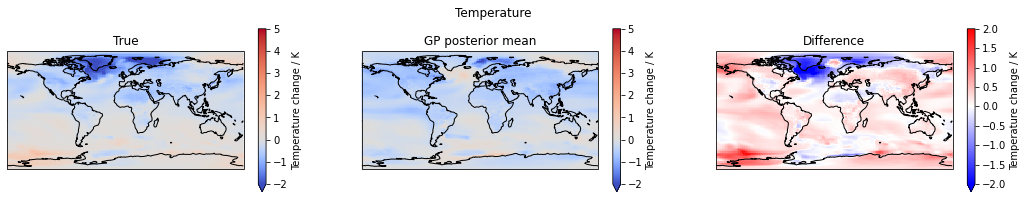

In [19]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2080,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2080,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2080,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

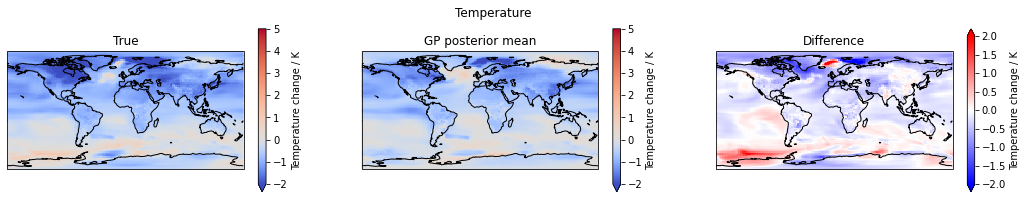

In [20]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(None,2030)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(None,2030)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(None,2030)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [21]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.52549183]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,9.320481941924744
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,9.787421469743302
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08726393373916355
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.7842086202712546
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.05525786173698117
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.02910737, 19.68465917, 2.05300333..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.1256950493017042
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[14.69221715, 15.50424992, 29.07986978..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07707965190121417


In [22]:
# Save predictions
posterior_tas_data.to_netcdf('climatebench-gp-posterior-mean-tas-test-aer-2019-2100.nc')
posterior_tas_std_data.to_netcdf('climatebench-gp-posterior-std-tas-test-aer-2019-2100.nc')